# Basic Artificial Neural Networks

In [9]:
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import matplotlib

%matplotlib inline

matplotlib.style.use('ggplot')

# Framework

In [10]:
%run assignment1_modules.ipynb

In [11]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    if state.get('old_grad'):
        flag = True
        old_dx = state['old_grad']
    else:
        flag = False
        old_dx = dx
    for cur_layer_x, cur_layer_dx, cur_layer_old_dx in zip(x,dx, old_dx): 
        for cur_x, cur_dx, cur_old_dx in zip(cur_layer_x,cur_layer_dx, cur_layer_old_dx):
            cur_old_grad = (config['momentum'] * cur_old_dx) if flag else 0 + config['learning_rate'] * cur_dx
            np.add(cur_x, -cur_old_grad, out=cur_x)
    old_dx = dx.copy()


In [12]:
def accuracy(A, B):
    return np.sum(np.argmax(A,axis=-1) == np.argmax(B, axis=-1)) * 1. / A.shape[0]

Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [13]:
# batch generator
def get_batches(X, Y, batch_size):
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [14]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

    
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = np.array(enc.fit_transform(y.reshape(-1, 1)).todense())


# X[X > 0.5] = 1
# X[X <= 0.5]= 0

perm = np.random.permutation(X.shape[0])
X = X[perm]
y = y[perm]

X_train, y_train = X[0:50000], y[0:50000]
X_val, y_val = X[50000:60000], y[50000:60000]
X_test, y_test = X[60000:], y[60000:]
    
print('Training', X_train.shape, y_train.shape)
print('Validation', X_val.shape, y_val.shape)
print('Test', X_test.shape, y_test.shape)

Training (50000, 784) (50000, 10)
Validation (10000, 784) (10000, 10)
Test (10000, 784) (10000, 10)


In [15]:
def trainNetwork(net, data, label, optimizer_config, epoch, batch_size, loss_history=[],  start = 0, end = 10000):
#     optimizer_config = {'learning_rate' : 0.1 * 2, 'momentum': 0.9}

    net.train()
    for i in range(epoch):
#         if i%3==0 : optimizer_config['learning_rate'] /= 2
        for x_batch, y_batch in get_batches(data, label, batch_size):
            net.zeroGradParameters()
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            sgd_momentum(net.getParameters()[start:end], 
                         net.getGradParameters()[start:end], 
                         optimizer_config,
                         optimizer_state)      
        loss_history.append(loss)
        print('Epoch: %d ' %(i))
        plt.plot(loss_history)
        plt.show()
#         print("  train accuracy:\t\t{:.2f} %".format(accuracy(net.forward(X_train), y_train)*100))
#         print("  validation accuracy:\t\t{:.2f} %".format(accuracy(net.forward(X_val), y_val)*100))

    net.evaluate()    
    

    #     acc = accuracy(net.forward(X), one_hot_y)


# Autoencoder (optional) 

This part is **OPTIONAL**, you may not do it. It will not be scored, but it is easy and interesting.

Now we are going to build a cool model, named autoencoder. The aim is simple: **encode** the data to a lower dimentional representation. Why? Well, if we can **decode** this representation back to original data with "small" reconstuction loss then we can store only compressed representation saving memory. But the most important thing is -- we can reuse trained autoencoder for classification. 
![](../imgs/autoencoder.png)

Picture from this [site](http://multithreaded.stitchfix.com/blog/2015/09/17/deep-style/).

Now implement an autoencoder:

Build it such that dimetionality inside autoencoder changes like that: 

$$784 \text{ (data)} -> 512 -> 256 -> 128 -> 30 -> 128 -> 256 -> 512 -> 784$$

Use **MSECriterion** to score the reconstruction. Use **BatchMeanNormalization** between **Linear** and **ReLU**. You may not use nonlinearity in bottleneck layer.

You may train it for 9 epochs with batch size = 256, initial lr = 0.1 droping by a factor of 2 every 3 epochs. The reconstruction loss should be about 6.0 and visual quality decent already.
Do not spend time on changing architecture, they are more or less the same. 

In [16]:
# Your code goes here. ################################################
criterion = MSECriterion()
# criterion = ClassNLLCriterion()
alpha = 1
auto = Sequential()
auto.add(Linear(784, 512))
auto.add(BatchMeanSubtraction(alpha))
auto.add(ReLU())
auto.add(Linear(512, 256))
auto.add(BatchMeanSubtraction(alpha))
auto.add(ReLU())
auto.add(Linear(256, 128))
auto.add(BatchMeanSubtraction(alpha))
auto.add(ReLU())
auto.add(Linear(128, 30))
auto.add(Linear(30, 128))
auto.add(BatchMeanSubtraction(alpha))
auto.add(ReLU())
auto.add(Linear(128, 256))
auto.add(BatchMeanSubtraction(alpha))
auto.add(ReLU())
auto.add(Linear(256, 512))
auto.add(BatchMeanSubtraction(alpha))
auto.add(ReLU())
auto.add(Linear(512, 784))
auto.add(ReLU())
# auto.add(Sigmoid())
print(auto)

Linear 784 -> 512
BatchMeanNormalization
ReLU
Linear 512 -> 256
BatchMeanNormalization
ReLU
Linear 256 -> 128
BatchMeanNormalization
ReLU
Linear 128 -> 30
Linear 30 -> 128
BatchMeanNormalization
ReLU
Linear 128 -> 256
BatchMeanNormalization
ReLU
Linear 256 -> 512
BatchMeanNormalization
ReLU
Linear 512 -> 784
ReLU



In [17]:
loss_history = []

In [18]:
# Iptimizer params
optimizer_config = {'learning_rate' : 0.001, 'momentum': 0.}
optimizer_state = {}

Epoch: 0 


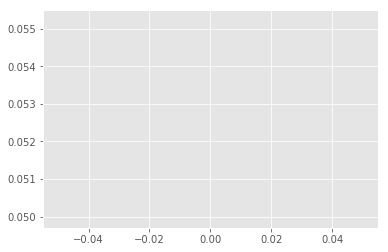

Epoch: 1 


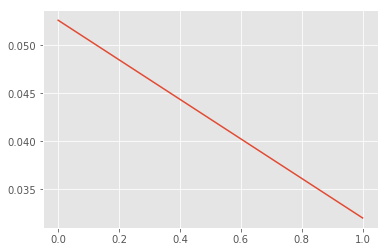

Epoch: 2 


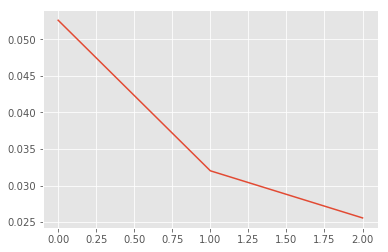

Epoch: 3 


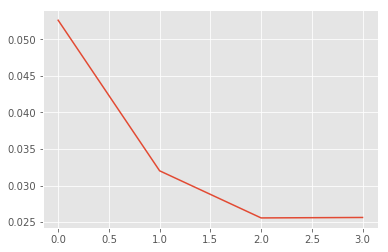

Epoch: 4 


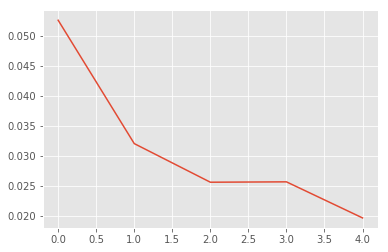

Epoch: 5 


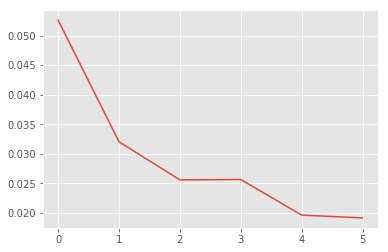

Epoch: 6 


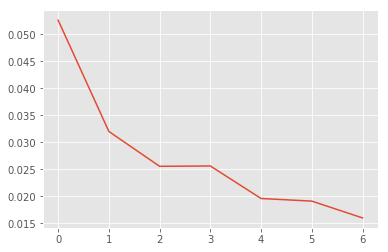

KeyboardInterrupt: 

In [19]:
trainNetwork(auto,X_train, X_train, optimizer_config,epoch=20, batch_size=50)

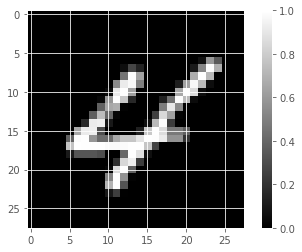

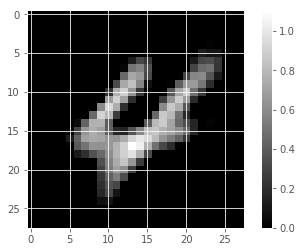

In [21]:
img = 69
plt.imshow(X_train[img].reshape(28,-1), cmap='gray')
plt.colorbar()
plt.show()
plt.imshow(auto.forward(X_train[img][None]).reshape(28,-1), cmap='gray')
plt.colorbar()
plt.show()

Some time ago NNs were a lot poorer and people were struggling to learn deep models. To train a classification net people were training autoencoder first (to train autoencoder people were pretraining single layers with [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)), then substituting the decoder part with classification layer (yeah, they were struggling with training autoencoders a lot, and complex techniques were used at that dark times). We are going to this now, fast and easy.  

In [22]:
all_modules = auto.modules

In [23]:
auto.modules = all_modules

In [24]:
all_modules[:10]
auto.modules = all_modules[:10]
auto.modules

[Linear 784 -> 512,
 BatchMeanNormalization,
 ReLU,
 Linear 512 -> 256,
 BatchMeanNormalization,
 ReLU,
 Linear 256 -> 128,
 BatchMeanNormalization,
 ReLU,
 Linear 128 -> 30]

In [25]:
small_network = Sequential()
small_network.add(Linear(30,100))
small_network.add(ReLU())
small_network.add(Linear(100,10))
small_network.add(SoftMax())
print(small_network)

In [26]:
X_train_30 = auto.forward(X_train)
X_test_30 = auto.forward(X_test)
X_val_30 = auto.forward(X_val)

In [27]:
print('Training', X_train_30.shape, y_train.shape)
print('Validation', X_val_30.shape, y_val.shape)
print('Test', X_test_30.shape, y_test.shape)

Training (50000, 30) (50000, 10)
Validation (10000, 30) (10000, 10)
Test (10000, 30) (10000, 10)


Epoch: 0 


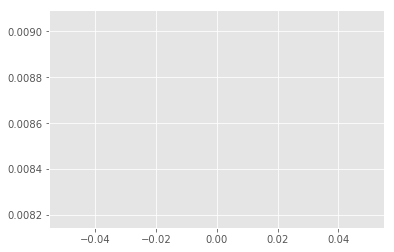

Epoch: 1 


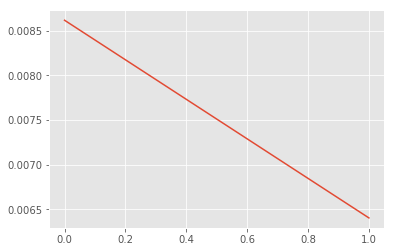

Epoch: 2 


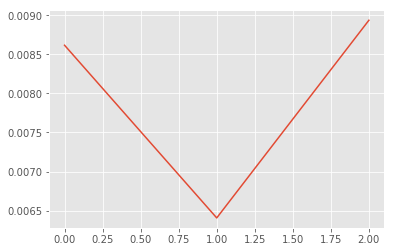

Epoch: 3 


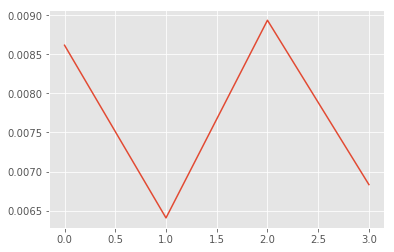

Epoch: 4 


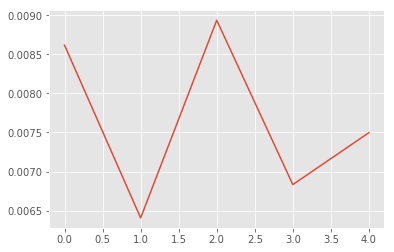

Epoch: 5 


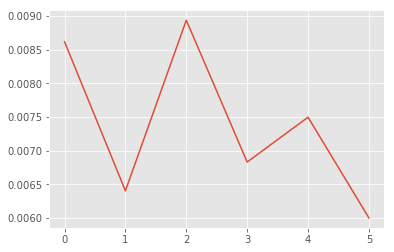

Epoch: 6 


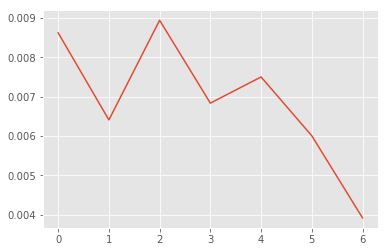

Epoch: 7 


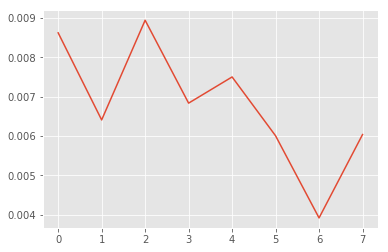

Epoch: 8 


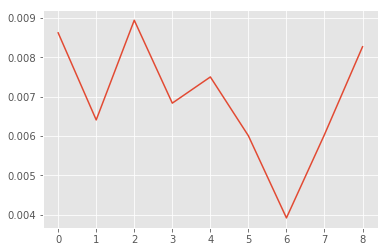

Epoch: 9 


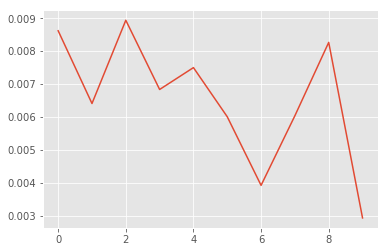

In [28]:
trainNetwork(small_network,X_train_30, y_train,
             optimizer_config= {'learning_rate' : 0.01, 'momentum': 0.},
             epoch=10, batch_size=500, loss_history=[] )

In [29]:
accuracy(small_network.forward(X_val_30), y_val)

0.95660000000000001

In [30]:

# Now build a logistic regression or small classification net

# Learn the weights
# Your code goes here. ################################################

# Now chop off decoder part
# (you may need to implement `remove` method for Sequential container) 
# Your code goes here. ################################################

# And add learned layers ontop.

# Now optimize whole model
# Your code goes here. ################################################

* What do you think, does it make sense to build real-world classifiers this way ? Did it work better for you than a straightforward one? Looks like it was not the same ~8 years ago, what has changed beside computational power? 

Run PCA with 30 components on the *train set*, plot original image, autoencoder and PCA reconstructions side by side for 10 samples from *validation set*.
Probably you need to use the following snippet to make aoutpencoder examples look comparible.

In [31]:
# np.clip(prediction,0,1)
#
# Your code goes here. ################################################

In [32]:
def with_svd(img, keep=5):
    u, s, v = np.linalg.svd(img)
    u = u[:,:keep]
    s = s[:keep]
    v = v[:keep]
    s = np.diag(s)
    return np.dot(u,np.dot(s,v))

In [33]:
auto.modules = all_modules

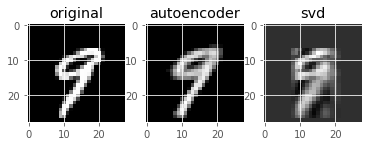

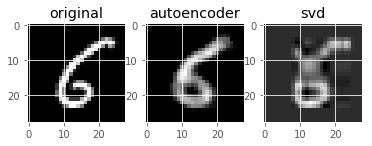

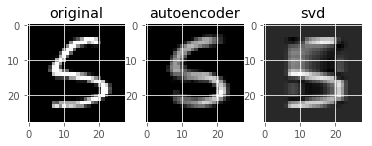

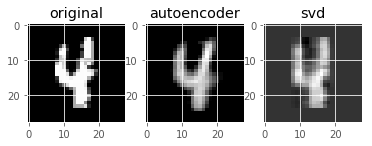

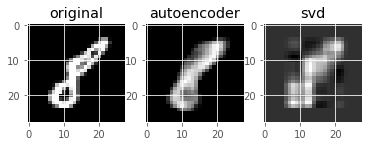

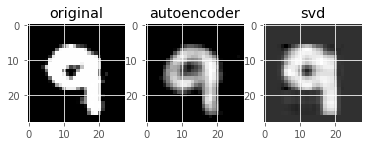

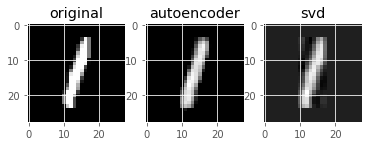

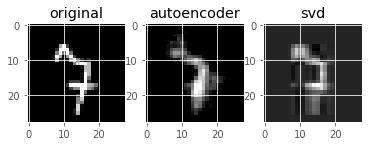

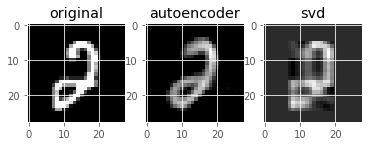

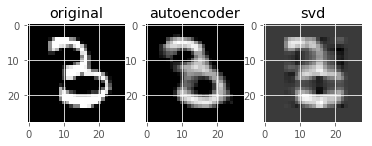

In [38]:

for i in range(10):
    x = np.random.randint(0,X_train.shape[0])
    img = X_train[x].reshape((28,28))
    f, axarr = plt.subplots(1,3, )
    axarr[0].imshow(img,cmap='gray')
    axarr[0].set_title('original')
    axarr[1].imshow(auto.forward(img.flatten()[None]).reshape(28,28),cmap='gray')
    axarr[1].set_title('autoencoder')
    axarr[2].imshow(with_svd(img,keep=3),cmap='gray')
    axarr[2].set_title('svd')